In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc


In [ ]:
df = pd.read_excel("raw/req/mansikamodel_major_species_2016_v0.3.xlsx", header=6)   # first sheet by default
arr = df.to_numpy()
totp_cc = arr[:,0]
totp_km = arr[:,1]
hp_cc = arr[:,2] # H+
hp_km = arr[:,3]
h2p_cc = arr[:,4]
h2p_km = arr[:,5]
h3p_cc = arr[:,6]
h3p_km = arr[:,7]
hep_cc = arr[:,8]
hep_km = arr[:,9]
mgp_cc = arr[:,10]
mgp_km = arr[:,11]
mghp_cc = arr[:,12]
mghp_km = arr[:,13]
# array 14 is empty
totm_cc = arr[:,15]
totm_km = arr[:,16]
em_cc = arr[:,17] # e-
em_km = arr[:,18]


Text(0.5, 1.0, 'Total Positive Ions Density vs Altitude')

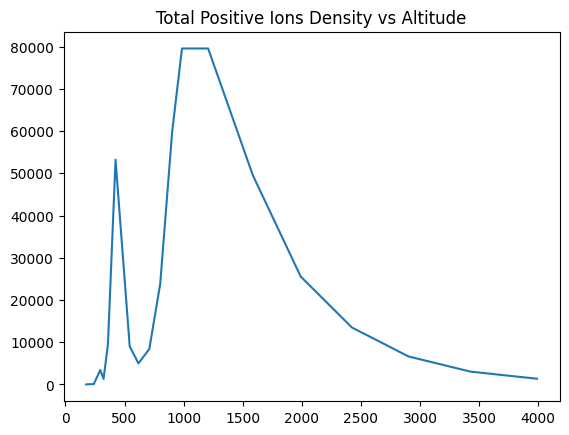

In [21]:
plt.plot(totp_km, totp_cc, label='Total Positive Ions')
plt.title('Total Positive Ions Density vs Altitude')

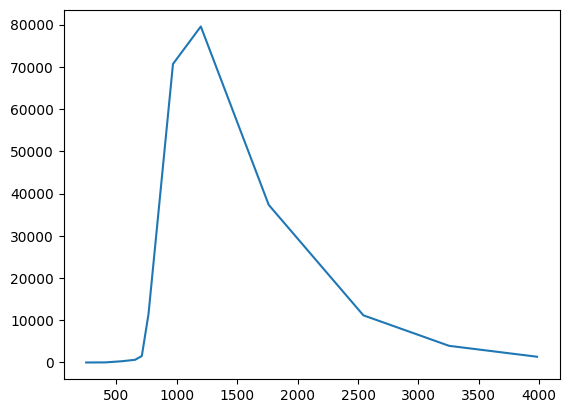

In [23]:
plt.plot(hp_km, hp_cc, label='H+')

In [ ]:
# fit gaussians

def multi_gaussian(x, *params):
    """
    Multi-Gaussian function.
    
    params = [A1, mu1, sigma1, A2, mu2, sigma2, ..., AN, muN, sigmaN]
    """
    n = len(params) // 3
    y = np.zeros_like(x)
    
    for i in range(n):
        A = params[3*i]
        mu = params[3*i + 1]
        sigma = params[3*i + 2]
        y += A * np.exp(-(x - mu)**2 / (2*sigma**2))
    
    return y


def fit_gaussians(x, y, n_peaks, p0=None, bounds=None):
    """
    Fit data with n Gaussians.

    Parameters
    ----------
    x, y : array-like
    n_peaks : int
        Number of Gaussian peaks
    p0 : list, optional
        Initial guess [A1, mu1, sigma1, ..., AN, muN, sigmaN]
    bounds : 2-tuple, optional
        Bounds for parameters ((low), (high))

    Returns
    -------
    popt : fitted parameters
    pcov : covariance matrix
    """
    if p0 is None:
        # crude default guess: evenly spaced, amplitude=max(y)/n_peaks, sigma=1
        A_guess = max(y)/n_peaks
        mu_guess = np.linspace(min(x), max(x), n_peaks)
        sigma_guess = [(max(x)-min(x))/(5*n_peaks)]*n_peaks
        p0 = []
        for A, mu, sigma in zip([A_guess]*n_peaks, mu_guess, sigma_guess):
            p0 += [A, mu, sigma]
    
    if bounds is None:
        bounds = (-np.inf, np.inf)
    
    popt, pcov = curve_fit(multi_gaussian, x, y, p0=p0, bounds=bounds)
    return popt, pcov


def plot_gaussian_fit(x, y, params, n_points=500, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    x_fit = np.linspace(min(x), max(x), n_points)
    y_fit = multi_gaussian(x_fit, *params)
    
    ax.scatter(x, y, label="Data")
    ax.plot(x_fit, y_fit, color='red', label="Fit")
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(True)
    
    return ax


def clean_out_nans(x, y):   
    mask = ~np.isnan(x) & ~np.isnan(y)
    return x[mask], y[mask]

In [42]:
# fit emgs
def multi_emg(x, *params):
    """
    Sum of n EMG (Exponentially Modified Gaussian) peaks.

    params = [A1, mu1, sigma1, lam1, A2, mu2, sigma2, lam2, ..., An, muN, sigmaN, lamN]
    """
    n = len(params) // 4
    y = np.zeros_like(x)
    
    for i in range(n):
        A = params[4*i]
        mu = params[4*i + 1]
        sigma = params[4*i + 2]
        lam = params[4*i + 3]
        
        y += A * (lam/2) * np.exp(lam/2 * (2*mu + lam*sigma**2 - 2*x)) * \
             erfc((mu + lam*sigma**2 - x)/(np.sqrt(2)*sigma))
    return y


def fit_emgs(x, y, n_peaks, p0=None, bounds=None):
    """
    Fit multiple EMG peaks to data.
    
    x, y : data
    n_peaks : int, number of EMG peaks
    p0 : optional, initial guess [A1, mu1, sigma1, lam1, ...]
    bounds : optional, bounds tuple ((low), (high))
    """
    # Clean NaNs/Infs
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    
    # Default initial guess
    if p0 is None:
        A_guess = max(y)/n_peaks
        mu_guess = np.linspace(min(x), max(x), n_peaks)
        sigma_guess = [max((max(x)-min(x))/(10*n_peaks), 1e-6)]*n_peaks # sigma_guess = max((max(x)-min(x))/10, 1e-6)
        lam_guess = [0.1]*n_peaks
        p0 = []
        for A, mu, sigma, lam in zip([A_guess]*n_peaks, mu_guess, sigma_guess, lam_guess):
            p0 += [A, mu, sigma, lam]
    
    # Default bounds
    if bounds is None:
        lower = []
        upper = []
        for i in range(n_peaks):
            lower += [0, min(x), 1e-6, 0]  # A≥0, sigma>0, lam≥0
            upper += [10*max(y), max(x), (max(x)-min(x)), 1.0] 
        bounds = (lower, upper)
    
    popt, pcov = curve_fit(multi_emg, x, y, p0=p0, bounds=bounds)
    return popt, pcov


def plot_multi_emg(x, y, params, n_points=500, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    n_peaks = len(params)//4
    x_fit = np.linspace(min(x), max(x), n_points)
    
    # Plot data
    ax.scatter(x, y, label="Data")
    
    # Plot individual peaks
    for i in range(n_peaks):
        p = params[4*i:4*(i+1)]
        y_peak = multi_emg(x_fit, *p)
        ax.plot(x_fit, y_peak, '--', label=f"Peak {i+1}")
    
    # Plot total fit
    y_fit = multi_emg(x_fit, *params)
    ax.plot(x_fit, y_fit, color='red', label="Total Fit")
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(True)
    
    return ax


Fitted parameters: [95781.66699386  1320.63424116  -306.48819211]


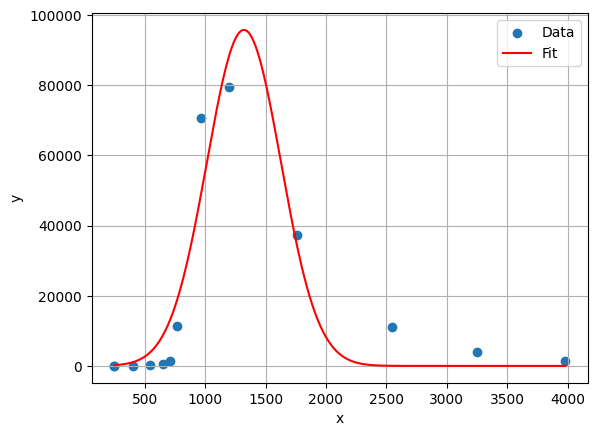

In [29]:
hp_km, hp_cc = clean_out_nans(hp_km, hp_cc)
params, cov = fit_gaussians(hp_km, hp_cc, n_peaks=1)

print("Fitted parameters:", params)

# Plot
plot_gaussian_fit(hp_km, hp_cc, params)
plt.show()

Fitted parameters: [1.24056829e+05 3.71088071e+03 3.50607205e+03 9.78933563e-03]


/tmp/ipykernel_1730/4005707443.py:17: RuntimeWarning: overflow encountered in exp
  y += A * (lam/2) * np.exp(lam/2 * (2*mu + lam*sigma**2 - 2*x)) * \
/tmp/ipykernel_1730/4005707443.py:17: RuntimeWarning: invalid value encountered in multiply
  y += A * (lam/2) * np.exp(lam/2 * (2*mu + lam*sigma**2 - 2*x)) * \


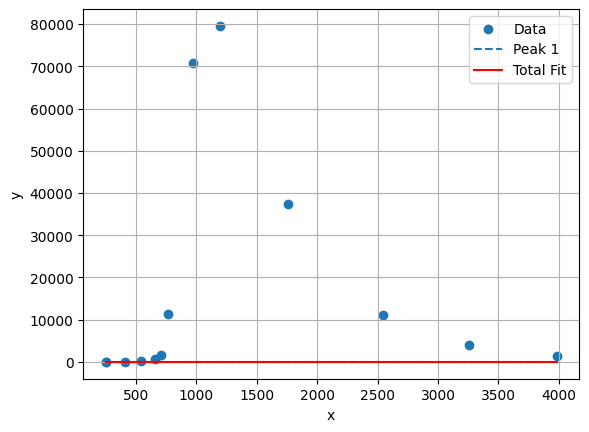

In [43]:
params, cov = fit_emgs(hp_km, hp_cc, n_peaks=1)
print("Fitted parameters:", params)

# Plot
plot_multi_emg(hp_km, hp_cc, params)
plt.show()

# Recreate the model

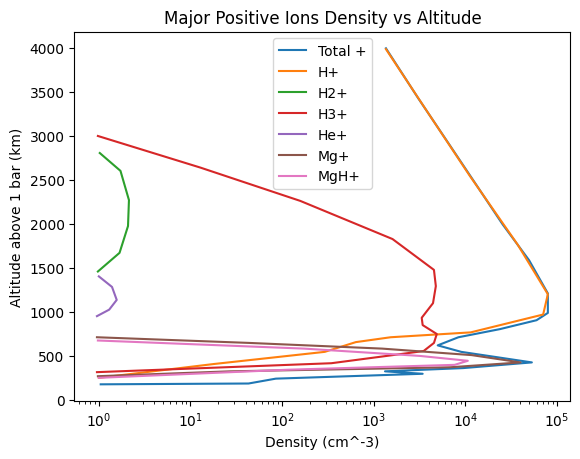

In [37]:
plt.plot(totp_cc, totp_km, label='Total +')
plt.plot(hp_cc, hp_km, label='H+')
plt.plot(h2p_cc, h2p_km, label='H2+')
plt.plot(h3p_cc, h3p_km, label='H3+')
plt.plot(hep_cc, hep_km, label='He+')
plt.plot(mgp_cc, mgp_km, label='Mg+')
plt.plot(mghp_cc, mghp_km, label='MgH+')
plt.title('Major Positive Ions Density vs Altitude')
plt.xscale('log')
plt.xlabel('Density (cm^-3)')
plt.ylabel('Altitude above 1 bar (km)')
plt.legend()

Text(0, 0.5, 'altitude above 1bar')

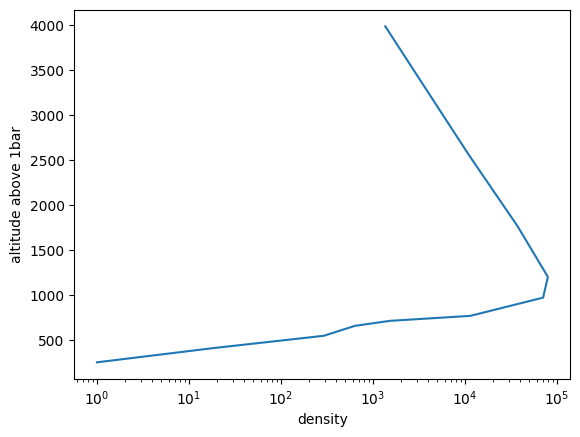

In [46]:
plt.plot(hp_cc, hp_km, label='H+')
plt.xscale('log')
plt.xlabel('density')
plt.ylabel('altitude above 1bar')